In [795]:
from logging import raiseExceptions
from tokenize import Double
import networkx as nx
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
import torch
torch.manual_seed(125)
import random
random.seed(125)
import torch_f as torch_f
from modelovae import Node, GRASSEncoder, GRASSDecoder, deserialize
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import statistics
from scipy.stats import wasserstein_distance


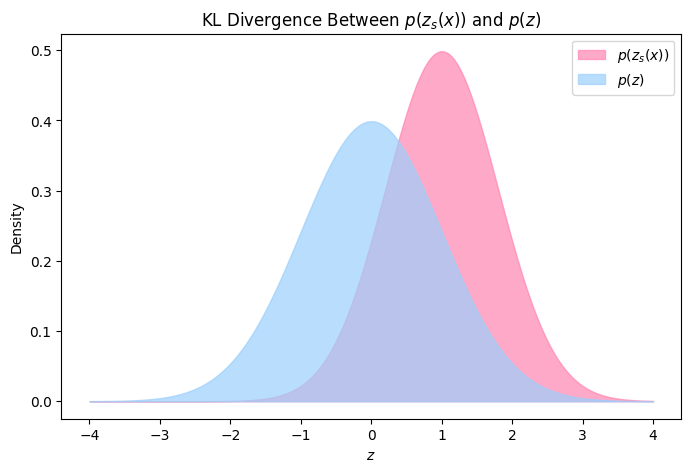

In [796]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define the x range
x = np.linspace(-4, 4, 1000)

# Define the two Gaussian distributions
mu_s, sigma_s = 1, 0.8    # Approximate posterior: p(z_s(x))
mu_prior, sigma_prior = 0, 1  # Prior: p(z)

# Calculate the PDFs
p_z_s = norm.pdf(x, mu_s, sigma_s)      # p(z_s(x))
p_z = norm.pdf(x, mu_prior, sigma_prior)  # p(z)

# Custom color palette
custom_palette = {"Real": "#9CCFFC", "Synthetic": "#FF85B1"}

# Plot the distributions
plt.figure(figsize=(8, 5))
plt.fill_between(x, p_z_s, color=custom_palette["Synthetic"], alpha=0.7, label='$p(z_s(x))$')
plt.fill_between(x, p_z, color=custom_palette["Real"], alpha=0.7, label='$p(z)$')

# Add KL divergence annotation
#plt.text(-3, 0.3, '$L_{KL} = D_{KL}(p(z_s(x)) \\, || \\, p(z))$', fontsize=12)

# Add labels and legend
plt.xlabel('$z$')
plt.ylabel('Density')
plt.title('KL Divergence Between $p(z_s(x))$ and $p(z)$')
plt.legend()
plt.grid(False)

plt.show()


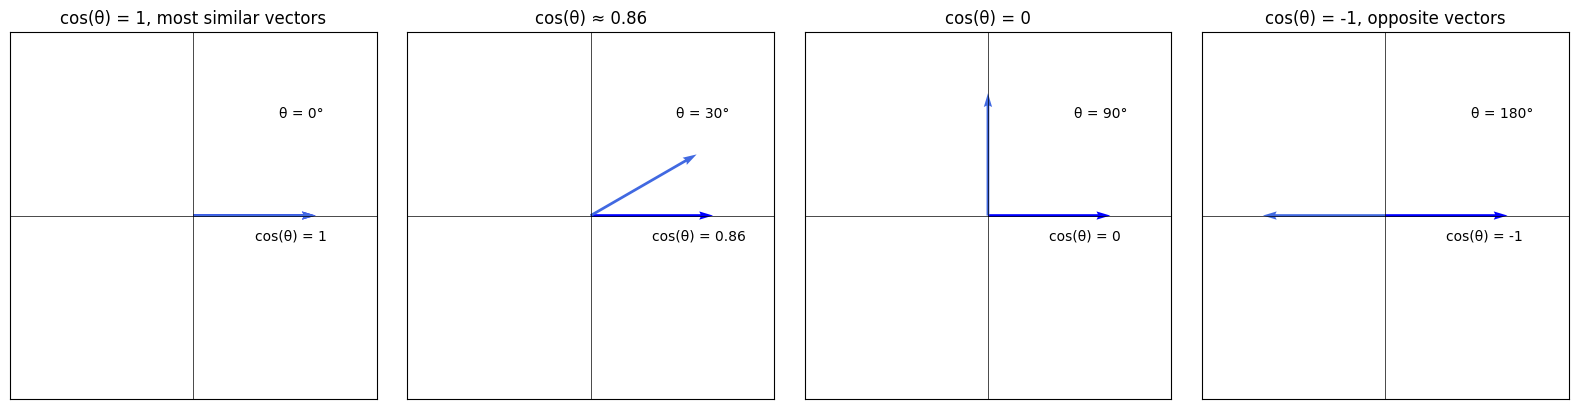

In [797]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot vectors and annotate angles
def plot_cosine_similarity(ax, theta, cosine_value, label):
    # Vector A (fixed) and B (rotated)
    A = np.array([1, 0])
    B = np.array([np.cos(np.radians(theta)), np.sin(np.radians(theta))])

    # Plot vectors
    ax.quiver(0, 0, *A, angles='xy', scale_units='xy', scale=1, color='blue', label='A')
    ax.quiver(0, 0, *B, angles='xy', scale_units='xy', scale=1, color='royalblue', label='B')

    # Set axis limits
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)

    # Plot angle and cosine value
    ax.text(0.5, -0.2, f"cos(θ) = {cosine_value}", fontsize=10)
    ax.text(0.7, 0.8, f"θ = {theta}°", fontsize=10)

    # Add labels
    ax.axhline(0, color='black',linewidth=0.5)
    ax.axvline(0, color='black',linewidth=0.5)
    ax.grid(False)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])

# Create subplots
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Plot examples for cos(θ)
plot_cosine_similarity(axes[0], 0, 1, "Most similar vectors")
plot_cosine_similarity(axes[1], 30, 0.86, "Small angle")
plot_cosine_similarity(axes[2], 90, 0, "Orthogonal vectors")
plot_cosine_similarity(axes[3], 180, -1, "Opposite vectors")

# Add titles
axes[0].set_title("cos(θ) = 1, most similar vectors")
axes[1].set_title("cos(θ) ≈ 0.86")
axes[2].set_title("cos(θ) = 0")
axes[3].set_title("cos(θ) = -1, opposite vectors")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [798]:
use_gpu = True
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")

def count_fn(f):
    def wrapper(*args, **kwargs):
        wrapper.count += 1
        return f(*args, **kwargs)
    wrapper.count = 0
    return wrapper

In [799]:
def traverseleaves(root, leaves):
    if root is not None:
        traverseleaves(root.left, leaves)
        if root.is_leaf():
            leaves.append(root)
        traverseleaves(root.right, leaves)
        return

def traverse(root):
        if root is not None:
            traverse(root.left)
            root.radius=root.radius.reshape(4)
            traverse(root.right)
            return

def traverseradius(root, rlist):
    if root is not None:
        traverseradius(root.left, rlist)
        rlist.append(root.radius[3])
        print("radius", root.radius[3])
        traverseradius(root.right, rlist)
        return 

def traversefeatures(root, features):
    if root is not None:
        traversefeatures(root.left, features)
        features.append(root.radius[3].cpu().item())
        traversefeatures(root.right, features)
        return features

def traverse_branch_features(root, branch_features, current_branch=None):
    if root is None:
        return

    # Initialize current branch if starting a new one
    if current_branch is None:
        current_branch = []

    # Add the current node's radius to the current branch
    current_branch.append(root.radius[3].cpu().item())

    # Check if it's a leaf node or bifurcation (has two children)
    is_leaf = root.left is None and root.right is None
    is_bifurcation = root.left is not None and root.right is not None

    if is_leaf or is_bifurcation:
        # Add the current branch to the list of branches
        branch_features.append(current_branch)
        # If it's a bifurcation, continue with new branches for left and right
        if is_bifurcation:
            traverse_branch_features(root.left, branch_features)
            traverse_branch_features(root.right, branch_features)
    else:
        # Continue down the current branch
        if root.left is not None:
            traverse_branch_features(root.left, branch_features, current_branch.copy())
        if root.right is not None:
            traverse_branch_features(root.right, branch_features, current_branch.copy())

# Usage example:
# branch_features = []
# traverse_branch_features(root, branch_features)
# print(branch_features)


def traversefeatures2(root, features):
    if root is not None:
        traversefeatures2(root.left, features)
        features.append(root.radius[0][3].cpu().item())
        traversefeatures2(root.right, features)
        return features          

def traverse_conexiones(root, tree):
        """
        traverse function will print all the node in the tree.
        """
        if root is not None:
            traverse_conexiones(root.left, tree)
            if root.right is not None:
                tree.append((root.data, root.right.data))
            if root.left is not None:
                tree.append((root.data, root.left.data))
            traverse_conexiones(root.right, tree)
            return tree

@count_fn
def createNode(data, radius,left = None, right = None):
        """
        Utility function to create a node.
        """
        return Node(data, radius, left, right)
 


def read_tree(filename, dir):
    with open('./' +dir +'/' +filename, "r") as f:
        byte = f.read() 
        return byte

def numerar_nodos(root, count):
    if root is not None:
        numerar_nodos(root.left, count)
        root.data = len(count)
        count.append(1)
        numerar_nodos(root.right, count)
        return 

def number_nodes(data_loader, batch_size):
    n_no = []
    qzero = 0
    qOne = 0
    qtwo = 0
    for batch in data_loader:
        for tree in batch:
            tree = tree[0]
            count = []
            n = tree.count_nodes(tree, count)
            n_no.append(len(n))
            li = []
            tree.traverseInorderChilds(tree, li)
            zero = [a for a in li if a == 0]
            one = [a for a in li if a == 1]
            two = [a for a in li if a == 2]
            qzero += len(zero)
            qOne += len(one)
            qtwo += len(two)

    nprom = np.mean(n_no)
    qzero /= len(data_loader)*batch_size
    qOne /= len(data_loader)*batch_size
    qtwo /= len(data_loader)*batch_size
    if round(qzero) == 0:
        qzero = 1
    if round(qOne) == 0:
        qOne = 1
    if round(qtwo) == 0:
        qtwo = 1
    mult = torch.tensor([1/round(qzero),1/round(qOne),1/round(qtwo)], device = device)
    return mult
    

In [800]:
def decode_testing(v, max, decoder, mult, min):
    def decode_node(v, max, decoder, mult, min):

        cl = decoder.nodeClassifier(v)
        _, label = torch.max(cl, 1)
        label = label.data
        
        
        if label == 1 and createNode.count <= max:
            right, radius = decoder.internalDecoder(v)
                
            d = createNode(1, radius) 
            
            d.right = decode_node(right, max, decoder, mult, min)
            return d

        elif label == 2 and createNode.count <= max:
            left, right, radius = decoder.bifurcationDecoder(v)
                
            d = createNode(1, radius)
            
            d.right = decode_node(right, max, decoder, mult, min)
            d.left = decode_node(left, max, decoder, mult, min)
        
            return d

       
        elif label == 0 : ##output del classifier
            radio = decoder.featureDecoder(v)
            return createNode(1,radio)  
        

    createNode.count = 0
    v = decoder.sample_decoder(v)
    dec = decode_node (v, max, decoder, mult, min)

    return dec

In [801]:
def my_collate(batch):
    return batch


class tDataset(Dataset):
    def __init__(self, l, dir, transform=None):
        self.names = l
        self.transform = transform
        self.data = [] #lista con las strings de todos los arboles
        for file in self.names:
            self.data.append(read_tree(file, dir))
        self.trees = []

        for tree in self.data:
            deserial = deserialize(tree)
            self.trees.append(deserial)
            

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        #file = self.names[idx]
        #string = read_tree(file)
        tree = self.trees[idx]
        name = self.names[idx]
        return tree

batch_size = 1

In [802]:
dataset_name = "Aneurisk"
p = str(15)
eps = str(0)+str(1)
d = "data/paper/" + dataset_name + "P" +p + "eps" + eps
print("d", d)
t_list = os.listdir(d)[:100]
print(len(t_list))
dataset = tDataset(t_list, d )
data_loader = DataLoader(dataset, batch_size = batch_size, shuffle=True, collate_fn=my_collate)
    
i = 0
d = None
d_nodos = []
n_bifo = []
for batch in data_loader:
    for input in batch:
        count = []
        numerar_nodos(input, count)
        d_nodos.append(len(count))
        li = []
        input.traverseInorderChilds(input, li)
        two = [a for a in li if a == 2]
        n_bifo.append(len(two))


d data/paper/AneuriskP15eps01
100


In [803]:
def distance(node1, node2):
    """
    Calculates the Euclidean distance between two nodes
    """
    if node1 is not None and node2 is not None:
        dist = ((node1.radius[0]-node2.radius[0])**2 + 
                (node1.radius[1]-node2.radius[1])**2 + 
                (node1.radius[2]-node2.radius[2])**2)**0.5
    else:
        dist = 0
    return dist

In [804]:
def tree_length(node):
    '''calcula el largo total del arbol'''
    if node is None:
        return 0

    stack = [(node, None)]
    length = 0

    while stack:
        curr, prev = stack.pop()

        if curr.left:
            stack.append((curr.left, curr))

        if curr.right:
            stack.append((curr.right, curr))

        if prev:
            length += distance(prev, curr)

    return length

In [805]:
def total_length(root, node, d):
    '''
    calcula la distancia del primer a ultimo nodo, arbol sin bifurcaciones
    '''
    if node.left:
        total_length(root, node.left, d)
    if node.isLeaf():
        #d = distance(root, node)
        d.append(distance(root, node))
        return 
    if node.right:
        total_length(root, node.right, d)

def total_path_length(node):
    """
    Calculates the total path length of the tree
    """
    if node is None:
        return 0
    else:
        return distance(node, node.left) + total_path_length(node.left) + distance(node, node.right) + total_path_length(node.right)

def tortuosity(root):
    """
    Calculates the tortuosity of the tree
    """
    total_path_length_value = total_path_length(root)
    d = []
    max_path_length_value = total_length(root,root, d)
    return total_path_length_value / d[0]

calculo tortuosidad, numero de bifurcaciones, largo total para el dataset

In [806]:
def collect_radius(node, radius_list):
    """
    Collects the radius of each node in the branch.
    """
    if node is not None:
        radius_list.append(node.radius[3])
        for child in node.children:
            print("////", node.children)
            collect_radius(child, radius_list)

import math

def collect_radius(node, radius_list):
    """
    Collects the radius of each node in the branch.
    """
    if node is not None:
        radius_list.append(node.radius[3])  # Append the current node's radius
        if node.left is not None:
            collect_radius(node.left, radius_list)
        if node.right is not None:
            collect_radius(node.right, radius_list)

# Usage example:
# branch_radii = []
# for each subtree (branch):
#     radius_list = []
#     collect_radius(nodoRaiz, radius_list)
#     branch_radii.append(radius_list)


def collect_length(node, length_list):
    """
    Collects the length of each segment in the branch.
    """
    if node is not None:
        if node.left is not None:
            # Calculate the Euclidean distance between the node and its left child
            length = euclidean_distance(node.radius[:3], node.left.radius[:3])
            length_list.append(length)
            collect_length(node.left, length_list)
        
        if node.right is not None:
            # Calculate the Euclidean distance between the node and its right child
            length = euclidean_distance(node.radius[:3], node.right.radius[:3])
            length_list.append(length)
            collect_length(node.right, length_list)

def euclidean_distance(coord1, coord2):
    """
    Calculates the Euclidean distance between two 3D points.
    """
    return math.sqrt(sum((c1 - c2) ** 2 for c1, c2 in zip(coord1, coord2)))

# Usage example:
# branch_lengths = []
# for each subtree (branch):
#     length_list = []
#     collect_length(nodoRaiz, length_list)
#     total_branch_length = sum(length_list)
#     branch_lengths.append(total_branch_length)


In [807]:
tortuosidad = []
n_bif = []
largo = []
n_nodes = []
ratio_radios = []
ratio_radios_por_rama = []
ratio_largos_por_rama = []
for batch in data_loader:
    for input in batch:

        graph = nx.Graph()
        input.toGraph(graph, 0 , False, flag = 0)
        degree1 = []

        for node in graph.nodes():
            if graph.degree(node) == 1:
                degree1.append(node)
       
        caminos = [ nx.shortest_path( graph, degree1[0], t ) for t in degree1[1:] ]
    
        subarboles = []
        for g in caminos:
            grafo = nx.Graph()
            grafo.add_nodes_from(g)
            et = []
            for node in grafo.nodes:
                edge = graph[node]
                edges = [a for a in list(edge.keys()) if a in g]
                edge_tuple = [(a,b) for a,b in zip([node]*len(edges), edges) ]
                for tuple in edge_tuple:
                    et.append(tuple)
            grafo.add_edges_from(et)
    
            aRecorrer = []
            numeroNodoInicial = degree1[0]
            r = graph.nodes[numeroNodoInicial]['radio']
            rad = list(graph.nodes[numeroNodoInicial]['posicion'])
            rad.append(r)

            nodoRaiz = Node( numeroNodoInicial, radius =  rad )

            for vecino in grafo.neighbors( numeroNodoInicial ):
                if vecino != numeroNodoInicial:
                    aRecorrer.append( (vecino, numeroNodoInicial,nodoRaiz ) )
            
            while len(aRecorrer) != 0:
                nodoAAgregar, numeroNodoPadre,nodoPadre = aRecorrer.pop(0)
                r = graph.nodes[nodoAAgregar]['radio']
                rad = list(graph.nodes[nodoAAgregar]['posicion'])
                rad.append(r)
                nodoActual = Node( nodoAAgregar, radius =  rad)
                nodoPadre.agregarHijo( nodoActual )
                for vecino in grafo.neighbors( nodoAAgregar ):
                    if vecino != numeroNodoPadre:
                        aRecorrer.append( (vecino, nodoAAgregar,nodoActual) )
            subarboles.append(nodoRaiz)
            tortuosidad.append(tortuosity(nodoRaiz))
            radius_list = []
            collect_radius(nodoRaiz, radius_list)
            average_radius = sum(radius_list) / len(radius_list)
            ratio_radios_por_rama.append(average_radius)
            length_list = []
            collect_length(nodoRaiz, length_list)
            average_length = sum(length_list) / len(length_list)
            ratio_largos_por_rama.append(average_length)
        li = []
        input.traverseInorderChilds(input, li)
        two = [a for a in li if a == 2]
        n_bif.append(len(two))
        total_path_length_value = tree_length(input)
        largo.append(total_path_length_value.cpu().item())
        count = []
        n = input.countNodes(input, count)
        n_nodes.append(len(n))
        features = []
        traversefeatures(input, features)
       
        #ratio_radios_por_rama.append([sum(lst) / len(lst) for lst in branch_features])
    
        ratio_radios.append(sum(features)/len(features))
        #print("ratio radios", ratio_radios)
        #print("ratio radios por ramas", ratio_radios_por_rama)

In [808]:
len(ratio_radios_por_rama)

381

In [809]:
len(ratio_largos_por_rama)

381

In [810]:
ratio_largos_por_rama

[0.033153825802924135,
 0.02714068285297668,
 0.032120310799880245,
 0.031034931084150324,
 0.029027056904002792,
 0.027628920810015754,
 0.02814963044432826,
 0.03556139500286595,
 0.03821482429261847,
 0.04576364610776237,
 0.047694635808665724,
 0.046544713561189666,
 0.049446592090873924,
 0.04716104959864289,
 0.046216822617029946,
 0.047419080889343365,
 0.04727922453764609,
 0.036003636977061396,
 0.03522225201907866,
 0.04819458414419353,
 0.042193213004295654,
 0.042181016390784434,
 0.04477326150151795,
 0.02384047678195542,
 0.024236179718119564,
 0.036936474086838054,
 0.0364962282540967,
 0.03030259439887593,
 0.03392175242480975,
 0.039833501489635825,
 0.03694592973323344,
 0.04964925425889261,
 0.05198634481424171,
 0.05739125750292184,
 0.05293109965186083,
 0.044079173157142555,
 0.05094545200438931,
 0.039536077718460974,
 0.04817083363960487,
 0.06075875102443075,
 0.029404779139634005,
 0.03139758906953522,
 0.045583983930645715,
 0.04470177511061821,
 0.0397792533

In [811]:
ratio_radios_por_rama

[0.021653898060321808,
 0.036887064847784735,
 0.04330315151862029,
 0.04304551859867984,
 0.02973809253809781,
 0.036315720592593324,
 0.0363799223740553,
 0.029986338689923286,
 0.034376556585942,
 0.04221309348940849,
 0.029124620258808135,
 0.03148658946156502,
 0.0314789379388094,
 0.03747069071336039,
 0.039735320334633194,
 0.034793133564692526,
 0.0447144164735901,
 0.021237906933362995,
 0.02181175204792193,
 0.022226870913679402,
 0.021956746830888416,
 0.031658416225885354,
 0.028450043639168143,
 0.029308349986014694,
 0.027882604827654773,
 0.04213260271554363,
 0.04239278228889252,
 0.04243478988265169,
 0.0401199726620689,
 0.036234031676461824,
 0.027785900588098326,
 0.0578367734560743,
 0.06919632049213195,
 0.07078991175211709,
 0.07355792190019901,
 0.02649685957779487,
 0.04828955171008905,
 0.04958104491233826,
 0.039583728593938494,
 0.030414149397984147,
 0.01626379363005981,
 0.018148201459553093,
 0.03980308927987751,
 0.032927999763112316,
 0.0216578126751950

calculo tortuosidad, numero de bifurcaciones para los generados

In [812]:
a = [1.,1.,1.]
mult = torch.Tensor(a)
latent_size = 64
Grassdecoder = GRASSDecoder(latent_size=latent_size, hidden_size=256, mult = mult.to(device))
Grassdecoder = Grassdecoder.to(device)
Grassdecoder.eval()
checkpoint = torch.load("output/" + dataset_name + "P" +p + "eps" + eps+ "-best-nuevoweight.pth")
#checkpoint = torch.load("output/" + dataset_name + eps+ "-best.pth")



Grassdecoder.load_state_dict(checkpoint['decoder_state_dict'])
epoch = checkpoint['epoch']

i = 0
n = 100
tortuosidad_generados = []
n_bif_generados = []
n_nodes_generados = []
largo_generados = []
ratio_radios_generados = []
ratio_radios_por_rama_generados = []
ratio_largos_por_rama_generados = []
with torch.no_grad():
    for i in range(n):
        noise = torch.randn(batch_size, latent_size).to(device)
        generated_images = decode_testing(noise, 100, Grassdecoder, mult, 1)
        count = []
        numerar_nodos(generated_images, count)
        graph = nx.Graph()
        generated_images.toGraph(graph, 0 , True, flag = 0)
        degree1 = []

        for node in graph.nodes():
            if graph.degree(node) == 1:
                degree1.append(node)
        caminos = [ nx.shortest_path( graph, degree1[0], t ) for t in degree1[1:] ]
        subarboles = []
        for g in caminos:
            grafo = nx.Graph()
            grafo.add_nodes_from(g)
            et = []
            for node in grafo.nodes:
                edge = graph[node]
                edges = [a for a in list(edge.keys()) if a in g]
                edge_tuple = [(a,b) for a,b in zip([node]*len(edges), edges) ]
                for tuple in edge_tuple:
                    et.append(tuple)
            grafo.add_edges_from(et)
    
            aRecorrer = []
            numeroNodoInicial = degree1[0]
            r = graph.nodes[numeroNodoInicial]['radio']
            rad = list(graph.nodes[numeroNodoInicial]['posicion'])
            rad.append(r)

            nodoRaiz = Node( numeroNodoInicial, radius =  rad )

            for vecino in grafo.neighbors( numeroNodoInicial ):
                if vecino != numeroNodoInicial:
                    aRecorrer.append( (vecino, numeroNodoInicial,nodoRaiz ) )
            
            while len(aRecorrer) != 0:
                nodoAAgregar, numeroNodoPadre,nodoPadre = aRecorrer.pop(0)
                r = graph.nodes[nodoAAgregar]['radio']
                rad = list(graph.nodes[nodoAAgregar]['posicion'])
                rad.append(r)
                nodoActual = Node( nodoAAgregar, radius =  rad)
                nodoPadre.agregarHijo( nodoActual )
                for vecino in grafo.neighbors( nodoAAgregar ):
                    if vecino != numeroNodoPadre:
                        aRecorrer.append( (vecino, nodoAAgregar,nodoActual) )
            subarboles.append(nodoRaiz)
            tortuosidad_generados.append(tortuosity(nodoRaiz))
            radius_list = []
            collect_radius(nodoRaiz, radius_list)
            average_radius = sum(radius_list) / len(radius_list)
            ratio_radios_por_rama_generados.append(average_radius)
            length_list = []
            collect_length(nodoRaiz, length_list)
            average_length = sum(length_list) / len(length_list)
            ratio_largos_por_rama_generados.append(average_length)
        li = []
        generated_images.traverseInorderChilds(generated_images, li)
        two = [a for a in li if a == 2]
        n_bif_generados.append(len(two))
        count = []
        n = generated_images.countNodes(generated_images, count)
        n_nodes_generados.append(len(n))
        traverse(generated_images)
        
        total_path_length_value = tree_length(generated_images)
        largo_generados.append(total_path_length_value.cpu().item())
        features = []
        
        traversefeatures(generated_images, features)
        ratio_radios_generados.append(sum(features)/len(features))
        

In [813]:
def tr(root):
        if root is not None:
            tr(root.left)
            root.radius[0][3]=root.radius[0][3]/10
            if root.radius[0][3]<0:
                root.radius[0][3]=0
            tr(root.right)
            return

In [814]:
enmax_palette = ["#FE7871", "#B50603"]

color_codes_wanted = ['pink', 'blue']
col = lambda x: enmax_palette[color_codes_wanted.index(x)]
#sns.set_palette(palette=enmax_palette)

HISTOGRAMAS

In [815]:
np.average(ratio_radios_por_rama_generados)

0.03864957364878553

In [816]:
np.average(ratio_radios_por_rama)

0.0348992936776117

In [817]:
np.average(ratio_radios_por_rama_generados)*100/np.average(ratio_radios_por_rama)

110.74600536566068

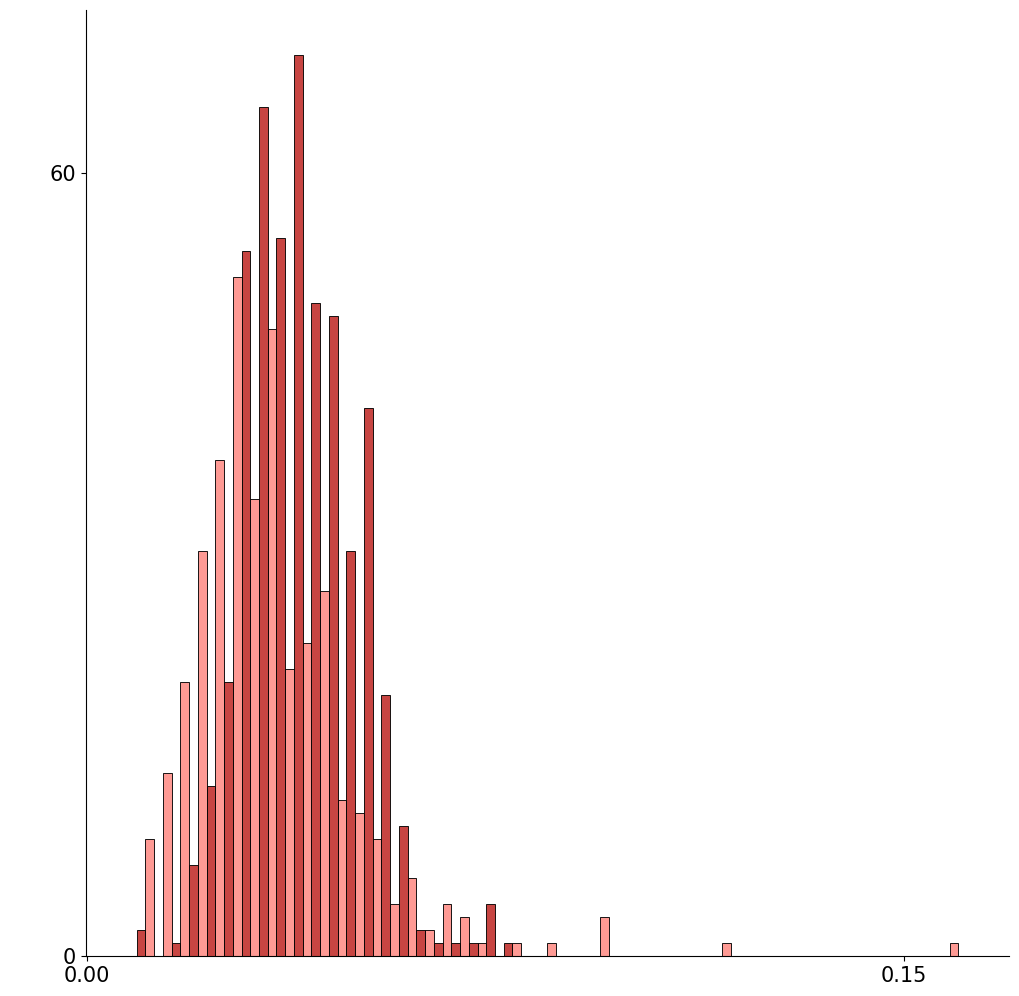

In [818]:
#plt.figure(figsize=(10,20))
##RADIO por rama
sns.displot([ratio_radios_por_rama, ratio_radios_por_rama_generados], multiple="dodge", height=10, aspect=1, legend=False, palette = enmax_palette)
ax = plt.gca()

#ax.set_title("Radius P{} {}".format(p, dataset_name), fontsize=35)

#ax.set_xlabel("Radius", fontsize = 25)
ax.set_ylabel("  ", fontsize = 25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

ax.xaxis.set_major_locator(MaxNLocator(nbins=1))
ax.yaxis.set_major_locator(MaxNLocator(nbins=1))
# get the patches for each dataset
patches = ax.patches
l = int(len(patches)/2)
patches_radius = patches[:l]
patches_radius_generados = patches[l:]

# get the counts for ratio_radios
counts_radius = [patch.get_height() for patch in patches_radius]

# get the counts for ratio_radios_generados
counts_radius_generados = [patch.get_height() for patch in patches_radius_generados]

#ax.legend(labels=["Synthetic samples", "Real samples"], fontsize = 25)

In [819]:
np.dot(counts_radius, counts_radius_generados)/(np.linalg.norm(counts_radius)*np.linalg.norm(counts_radius_generados))

0.857417031235328

In [820]:
emd_radios = wasserstein_distance(range(len(counts_radius)), range(len(counts_radius_generados)), counts_radius, counts_radius_generados)
emd_radios

1.8676460532613777

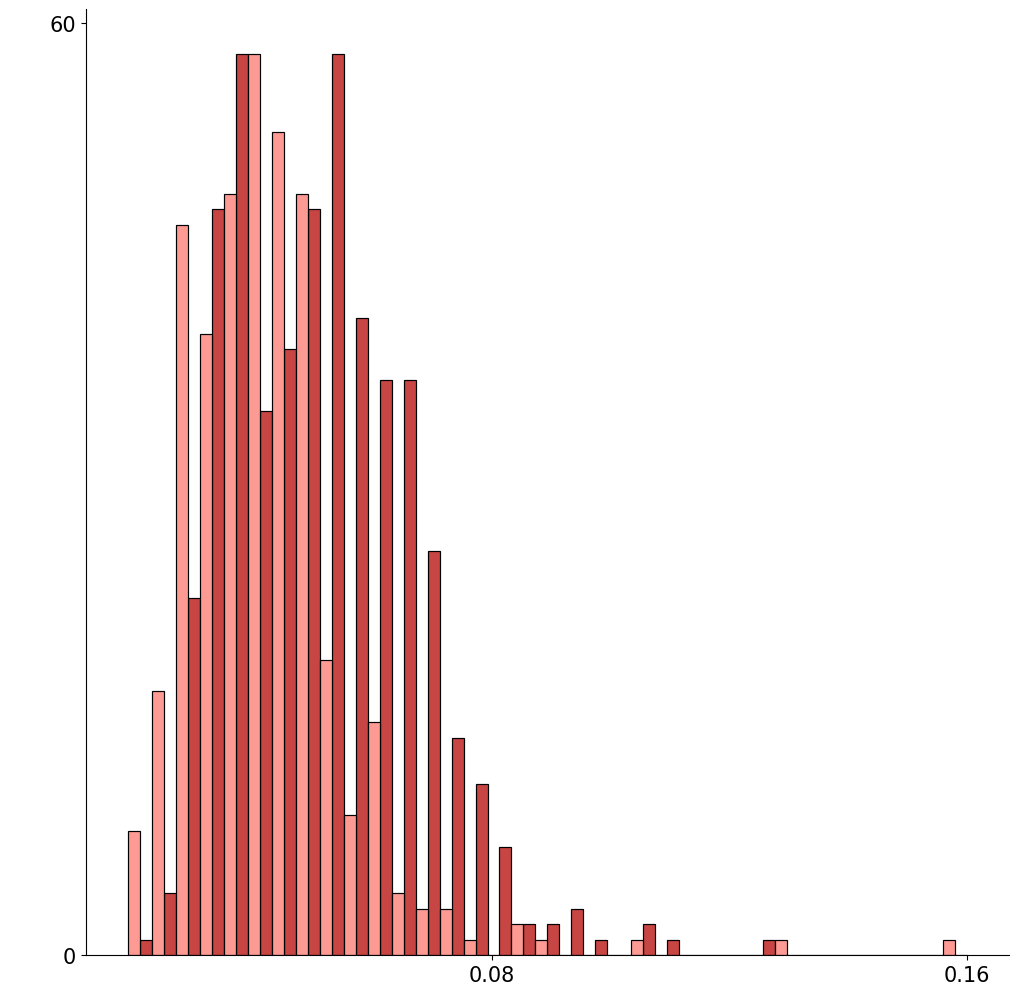

In [821]:
#plt.figure(figsize=(10,20))
##RLARGO por rama
sns.displot([ratio_largos_por_rama, ratio_largos_por_rama_generados], multiple="dodge", height=10, aspect=1, legend=False, palette = enmax_palette)
ax = plt.gca()

#ax.set_title("Radius P{} {}".format(p, dataset_name), fontsize=35)

#ax.set_xlabel("Radius", fontsize = 25)
ax.set_ylabel("  ", fontsize = 25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

ax.xaxis.set_major_locator(MaxNLocator(nbins=1))
ax.yaxis.set_major_locator(MaxNLocator(nbins=1))
# get the patches for each dataset
patches = ax.patches
l = int(len(patches)/2)
patches_radius = patches[:l]
patches_radius_generados = patches[l:]

# get the counts for ratio_radios
counts_radius = [patch.get_height() for patch in patches_radius]

# get the counts for ratio_radios_generados
counts_radius_generados = [patch.get_height() for patch in patches_radius_generados]

#ax.legend(labels=["Synthetic samples", "Real samples"], fontsize = 25)

In [822]:
np.dot(counts_radius, counts_radius_generados)/(np.linalg.norm(counts_radius)*np.linalg.norm(counts_radius_generados))

0.8223253582290164

In [823]:
emd_radios = wasserstein_distance(range(len(counts_radius)), range(len(counts_radius_generados)), counts_radius, counts_radius_generados)
emd_radios

2.3018109710234116

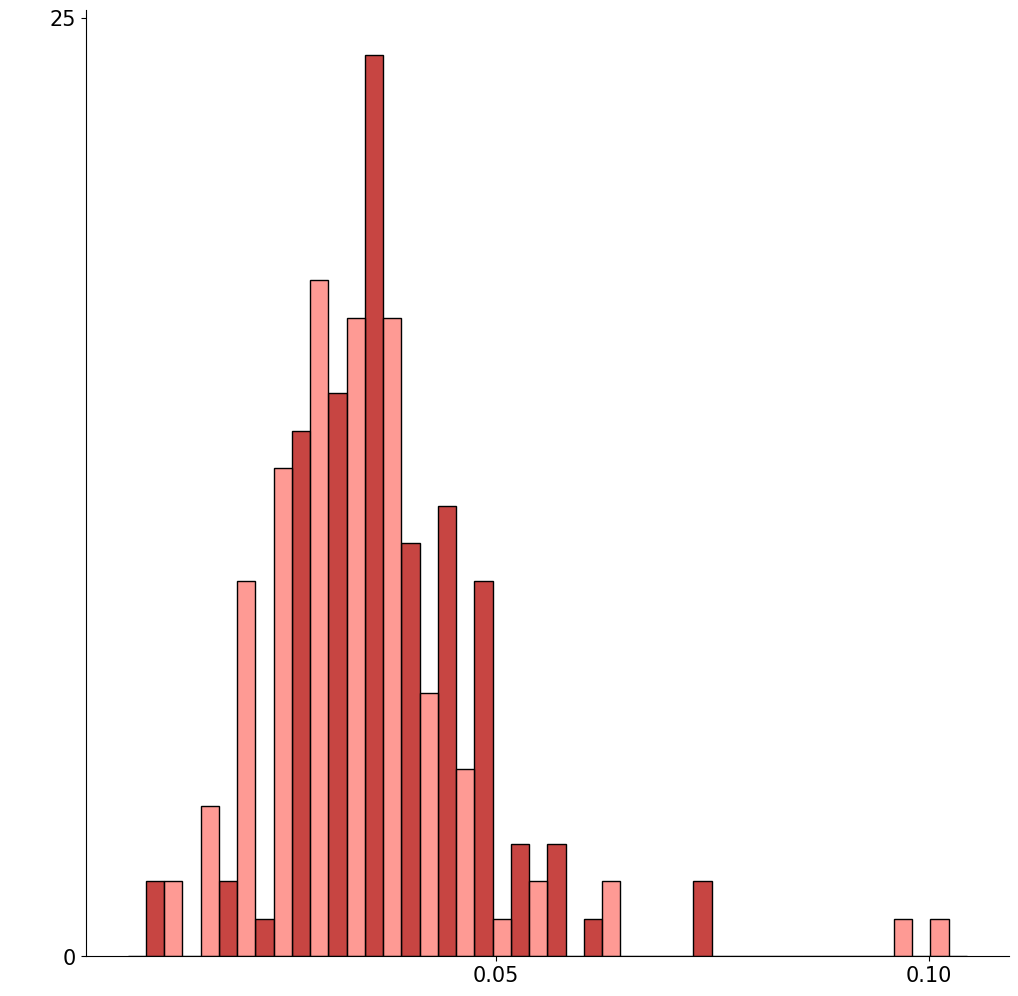

In [824]:
#plt.figure(figsize=(10,20))
##RADIO
sns.displot([ratio_radios, ratio_radios_generados], multiple="dodge", height=10, aspect=1, legend=False, palette = enmax_palette)
ax = plt.gca()

#ax.set_title("Radius P{} {}".format(p, dataset_name), fontsize=35)

#ax.set_xlabel("Radius", fontsize = 25)
ax.set_ylabel("  ", fontsize = 25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

ax.xaxis.set_major_locator(MaxNLocator(nbins=1))
ax.yaxis.set_major_locator(MaxNLocator(nbins=1))
# get the patches for each dataset
patches = ax.patches
l = int(len(patches)/2)
patches_radius = patches[:l]
patches_radius_generados = patches[l:]

# get the counts for ratio_radios
counts_radius = [patch.get_height() for patch in patches_radius]

# get the counts for ratio_radios_generados
counts_radius_generados = [patch.get_height() for patch in patches_radius_generados]

#ax.legend(labels=["Synthetic samples", "Real samples"], fontsize = 25)

In [825]:
np.dot(counts_radius, counts_radius_generados)/(np.linalg.norm(counts_radius)*np.linalg.norm(counts_radius_generados))

0.9057538948140841

In [826]:
values = [0.946306381992226, 0.8893526816459894, 0.9388776593013862]

# Mean
mean = statistics.mean(values)
print("Mean:", mean)

# Standard Deviation
std_dev = statistics.stdev(values)
print("Standard Deviation:", std_dev)

Mean: 0.9248455743132006
Standard Deviation: 0.0309613557942636


In [827]:
from scipy import stats

# Example cosine similarity score (replace with your actual score)
cosine_similarity_score = 0.946306381992226

# Define null hypothesis value (e.g., expected similarity score)
null_hypothesis_value = 1  # Adjust this value according to your hypothesis

# Perform one-sample t-test
t_statistic, p_value = stats.ttest_1samp(cosine_similarity_score, null_hypothesis_value)
print("t-statistic:", t_statistic)
print("p-value:", p_value)

t-statistic: nan
p-value: nan


/home/eiarussi/.local/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:502: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/home/eiarussi/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/eiarussi/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


In [828]:
import numpy as np

# Example cosine similarity scores (replace with your actual scores)
cosine_similarity_scores = [0.946306381992226, 0.8893526816459894, 0.9388776593013862]

# Number of bootstrap samples
num_bootstrap_samples = 1000

# Generate bootstrap samples
bootstrap_scores = []
for _ in range(num_bootstrap_samples):
    bootstrap_sample = np.random.choice(cosine_similarity_scores, size=len(cosine_similarity_scores), replace=True)
    bootstrap_scores.append(np.mean(bootstrap_sample))

# Calculate statistics of interest
bootstrap_mean = np.mean(bootstrap_scores)
bootstrap_std = np.std(bootstrap_scores)
confidence_interval = np.percentile(bootstrap_scores, [5, 95])

# Assess fidelity
if confidence_interval[0] <= np.mean(cosine_similarity_scores) <= confidence_interval[1]:
    print("Observed cosine similarity score is consistent with the variability expected under bootstrapping.")
else:
    print("Observed cosine similarity score is not consistent with the variability expected under bootstrapping.")

print("Bootstrap Mean:", bootstrap_mean)
print("Bootstrap Standard Deviation:", bootstrap_std)
print("95% Confidence Interval:", confidence_interval)

Observed cosine similarity score is consistent with the variability expected under bootstrapping.
Bootstrap Mean: 0.9252566311006762
Bootstrap Standard Deviation: 0.014603613740931007
95% Confidence Interval: [0.90586101 0.94383014]


tortuosidad

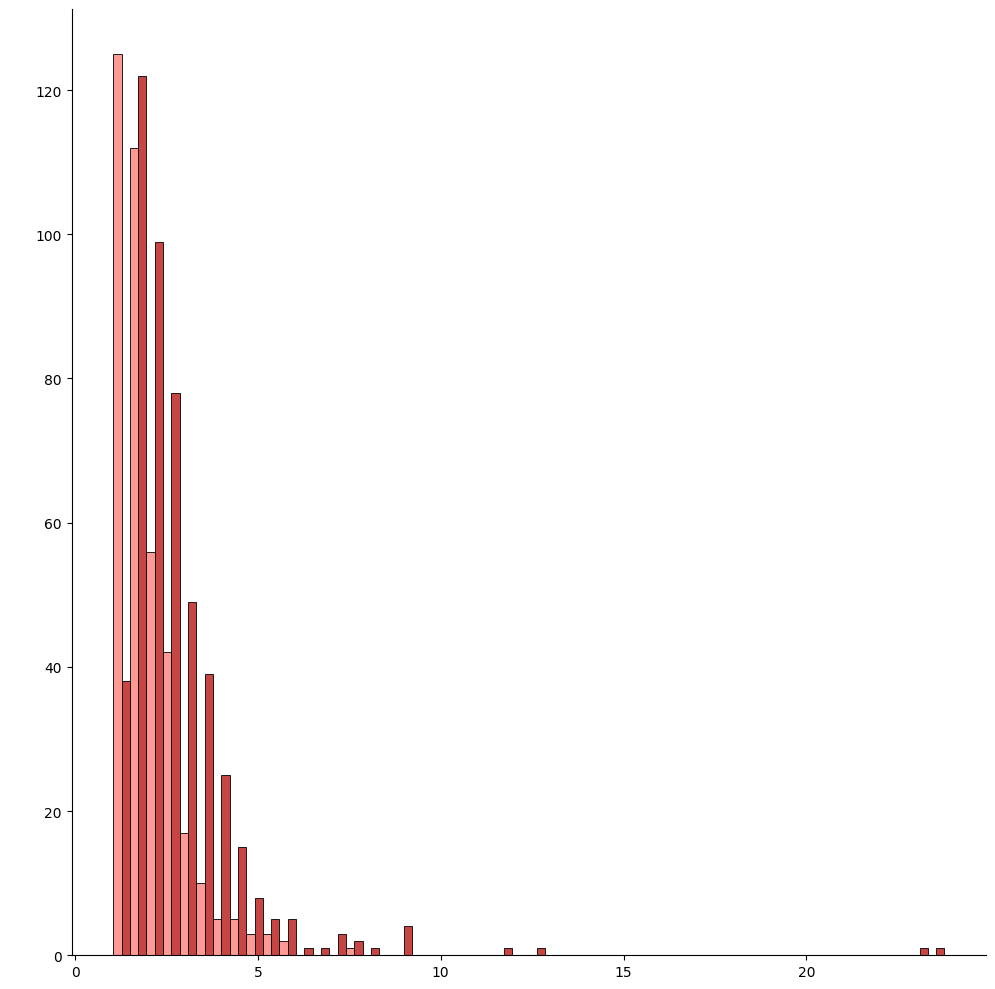

In [829]:
sns.displot([tortuosidad, tortuosidad_generados], multiple="dodge", height=10, aspect=1, legend=False, palette = enmax_palette, bins = 50)
ax = plt.gca()
#ax.legend(labels=["Synthetic Samples", "Real samples"], fontsize = 25)
#ax.set_title("Tortuosity P{} {}".format(p, dataset_name), fontsize=35)
#ax.set_xlabel("Tortuosity", fontsize = 25)
ax.set_ylabel(" ", fontsize = 15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)


# get the patches for each dataset
patches = ax.patches
l = int(len(patches)/2)
patches_tortuosidad = patches[:l]
patches_tortuosidad_generados = patches[l:]

# get the counts for ratio_radios
counts_tortuosidad = [patch.get_height() for patch in patches_tortuosidad]

# get the counts for ratio_radios_generados
counts_tortuosidad_generados = [patch.get_height() for patch in patches_tortuosidad_generados]
#ax.xaxis.set_major_locator(MaxNLocator(nbins=1, prune='both'))


In [830]:
np.dot(counts_tortuosidad, counts_tortuosidad_generados)/(np.linalg.norm(counts_tortuosidad)*np.linalg.norm(counts_tortuosidad_generados))

0.8135569708258236

Largo total

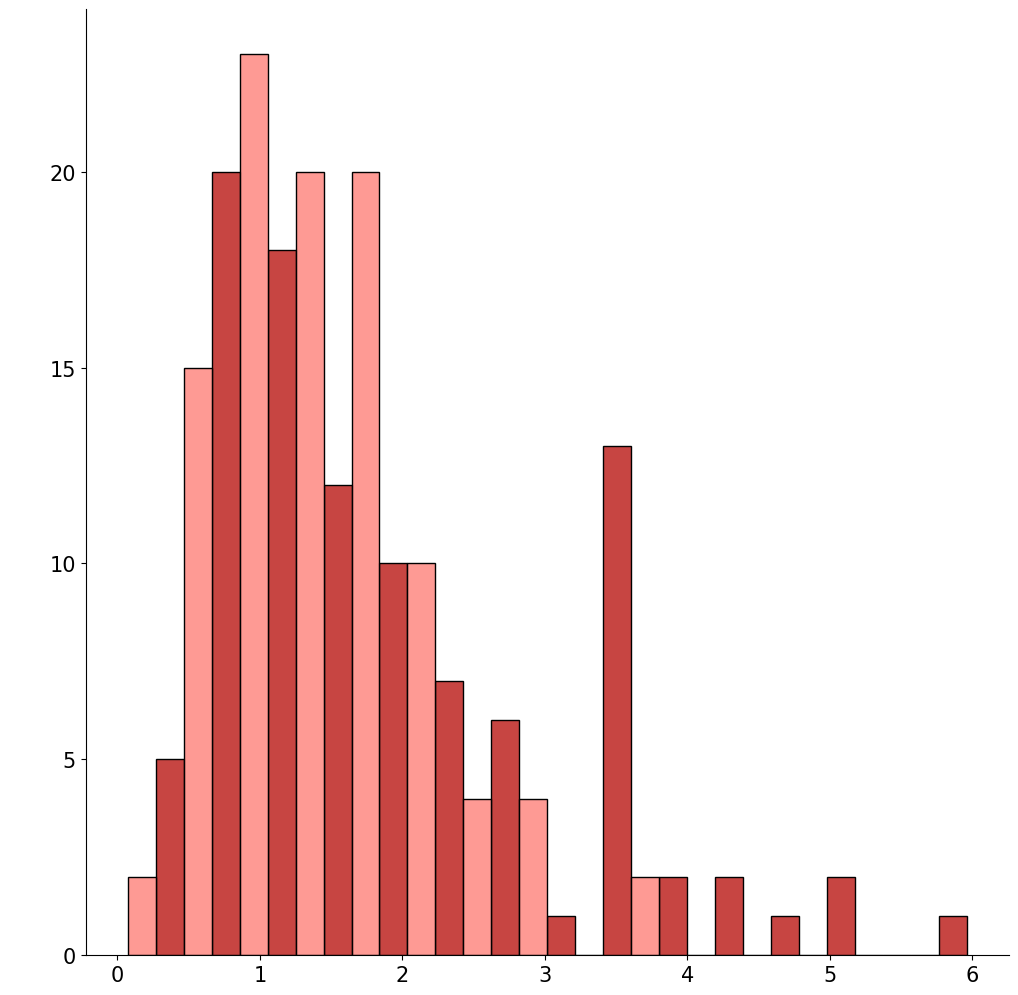

In [831]:
sns.displot([largo, largo_generados], multiple="dodge", height=10, aspect=1, legend=False, palette=enmax_palette)
ax = plt.gca()
#ax.legend(labels=["Synthetic Samples", "Real samples" ], fontsize = 25)
#ax.set_title("Length P{} {}".format(p, dataset_name), fontsize=35)

#ax.set_xlabel("Length", fontsize = 25)
ax.set_ylabel("  ", fontsize = 25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# get the patches for each dataset
patches = ax.patches
l = int(len(patches)/2)
patches_length = patches[:l]
patches_length_generados = patches[l:]



counts = [patch.get_height() for patch in patches]
# get the counts for ratio_radios
counts_length = [patch.get_height() for patch in patches_length]

# get the counts for ratio_radios_generados
counts_length_generados = [patch.get_height() for patch in patches_length_generados]

In [832]:
np.dot(counts_length, counts_length_generados)/(np.linalg.norm(counts_length)*np.linalg.norm(counts_length_generados))

0.8658592985269553